# Imports

In [1]:
import pickle
import os
import csv
import string
import librosa
import shutil
import torch
import random
import math
import h5py
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
from torch.utils.data.sampler import BatchSampler
from librosa.util import normalize
from librosa.util import fix_length
from google.colab import drive
from google.colab import runtime
from itertools import combinations
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import models, transforms
from torchvision.transforms import v2
from torchsummary import summary
from torchvision.datasets import MNIST
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')
dl = False

Mounted at /content/drive


# Data

Loading Data

In [2]:
# Load training data from HDF5 file
with h5py.File('/content/drive/My Drive/NeuraBeat/Data/train_data_small_melspec.h5', 'r') as train_file:
    train_data = np.array(train_file['data'])
    train_labels = np.array(train_file['labels'], dtype='S')

# Load validation data from HDF5 file
with h5py.File('/content/drive/My Drive/NeuraBeat/Data/val_data_small_melspec.h5', 'r') as val_file:
    val_data = np.array(val_file['data'])
    val_labels = np.array(val_file['labels'], dtype='S')

train_labels = [label.decode('utf-8') for label in train_labels]
val_labels = [label.decode('utf-8') for label in val_labels]

train_data = np.transpose(train_data, (0, 2, 3, 1))
val_data = np.transpose(val_data, (0, 2, 3, 1))

genre_to_int = {genre: i for i, genre in enumerate(sorted(set(train_labels)))}
print(genre_to_int)

# Encode the labels using the mapping
train_labels = torch.tensor([genre_to_int[label] for label in train_labels])
val_labels = torch.tensor([genre_to_int[label] for label in val_labels])

{'Electronic': 0, 'Experimental': 1, 'Folk': 2, 'Hip-Hop': 3, 'Instrumental': 4, 'International': 5, 'Pop': 6, 'Rock': 7}


In [3]:
print(train_data.shape)
print(val_data.shape)

(6374, 64, 162, 1)
(1594, 64, 162, 1)


Balanced Batch Sampler

In [4]:
class BalancedBatchSampler(BatchSampler):
    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

Data Augmentation

In [5]:
class TrainDataAugmentation(nn.Module):
    def __init__(self):
        super(TrainDataAugmentation, self).__init__()
        self.transforms = v2.Compose([
            v2.ToImage(),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomAffine(degrees=(0, 30), translate=(0.2, 0.2)),
            v2.RandomRotation(degrees=(0, 180)),
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=(0.0951,), std=(0.0933,))
        ])

    def forward(self, image):
        augmented_image = self.transforms(image)
        return augmented_image

class ValDataAugmentation(nn.Module):
    def __init__(self):
        super(ValDataAugmentation, self).__init__()
        self.transforms = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=(0.0951,), std=(0.0933,))
        ])

    def forward(self, image):
        augmented_image = self.transforms(image)
        return augmented_image

Create Dataset

In [6]:
class AudioDataset(Dataset):
    def __init__(self, input_data, input_labels, transform):
        self.input_data = input_data
        self.input_labels = input_labels
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        song = self.input_data[idx]
        genre = self.input_labels[idx]
        if self.transform:
            song = self.transform(song)

        return song, genre

audio_train_dataset = AudioDataset(input_data=train_data, input_labels=train_labels, transform=TrainDataAugmentation())
audio_val_dataset = AudioDataset(input_data=val_data, input_labels=val_labels, transform=ValDataAugmentation())

audio_train_batch_sampler = BalancedBatchSampler(audio_train_dataset.input_labels, n_classes=8, n_samples=64)
audio_val_batch_sampler = BalancedBatchSampler(audio_val_dataset.input_labels, n_classes=8, n_samples=64)

audio_train_loader = DataLoader(audio_train_dataset, batch_sampler=audio_train_batch_sampler, pin_memory=True)
audio_val_loader = DataLoader(audio_val_dataset, batch_sampler=audio_val_batch_sampler, pin_memory=True)

In [7]:
def dataset_mean_std(data_loader):
  nimages = 0
  mean = 0.
  std = 0.
  for batch, _ in data_loader:
      # Rearrange batch to be the shape of [B, C, W * H]
      batch = batch.view(batch.size(0), batch.size(1), -1)
      # Update total number of images
      nimages += batch.size(0)
      # Compute mean and std here
      mean += batch.float().mean(2).sum(0)
      std += batch.float().std(2).sum(0)

  # Final step
  mean /= nimages
  std /= nimages

  print("Training set mean", mean)
  print("Training set std", std)

  return mean, std

dataset_mean_std(audio_train_loader)

Training set mean tensor([0.0456])
Training set std tensor([1.0304])


(tensor([0.0456]), tensor([1.0304]))

# Model

TODO \\

1. Recurrent architecture
2. KAN



Print Layer (debugging)

In [8]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print("X shape:", x.shape)
        return x


Positional Encoding

In [9]:
# From: https://github.com/wzlxjtu/PositionalEncoding2D
class PositionalEncoding1d(nn.Module):
    def __init__(self, d_model, length):
        super(PositionalEncoding1d, self).__init__()
        if d_model % 2 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dim (got dim={:d})".format(d_model))
        pe = torch.zeros(length, d_model)
        position = torch.arange(0, length).unsqueeze(1)
        div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                            -(math.log(10000.0) / d_model)))
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe


class PositionalEncoding2d(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding2d, self).__init__()
        if d_model % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dimension (got dim={:d})".format(d_model))
        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                            -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe

Separable Convolution 2D Layer

In [10]:
# Inspired by: https://github.com/reshalfahsi/separableconv-torch
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class SeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=1, bias=False):
        super(SeparableConv1d, self).__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

Residual Block

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, num_layers: int, pool: bool, short: bool, two_dim: bool):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.pooling = pool
        self.short = short
        self.two_dim = two_dim

        self.inconv = nn.Sequential(
            SeparableConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False),
            nn.SELU()
        )

        layers = []
        for _ in range(num_layers - 1):
            if self.two_dim:
              layers.append(SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False))
            else:
              layers.append(SeparableConv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False))
            layers.append(nn.SELU())
        self.convlayers = nn.Sequential(*layers)

        if self.pooling:
            if self.two_dim:
              self.pool = nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=1)
              self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
            else:
              self.pool = nn.MaxPool1d(kernel_size=kernel_size, stride=2, padding=1)
              self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
        else:
            if self.two_dim:
              self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
            else:
              self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)

        self.sact = nn.SELU()

    def forward(self, x):
        out = self.inconv(x)
        out = self.convlayers(out)

        if self.pooling:
            out = self.pool(out)

        if self.short:
            shortcut = self.shortcut(x)
            out = out + shortcut
            out = self.sact(out)

        return out

Embedding Model

In [12]:
class EmbeddingModel(nn.Module):
    def __init__(self):
      super(EmbeddingModel, self).__init__()
      self.input = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
                                 nn.SELU())
      self.positional_encoding = PositionalEncoding2d(64, 64, 162)


      self.conv_layers = nn.Sequential(
          ResidualBlock(in_channels=64, out_channels=64, kernel_size=3, num_layers=3, pool=True, short=True, two_dim=True),
          ResidualBlock(in_channels=64, out_channels=128, kernel_size=3, num_layers=3, pool=True, short=True, two_dim=True),
          ResidualBlock(in_channels=128, out_channels=256, kernel_size=3, num_layers=3, pool=True, short=True, two_dim=True),
      )

      self.attention = nn.MultiheadAttention(embed_dim=168, num_heads=8, dropout=0.5, batch_first=True)

      self.dense_layers = nn.Sequential(
        nn.Linear(in_features=256, out_features=512, bias=False),
        nn.SELU(),
        nn.Linear(in_features=512, out_features=256, bias=False),
        nn.SELU(),
        nn.Dropout(0.5),
      )

      self.output = nn.Linear(256, 2)

    def forward(self, x):
      x = self.input(x)
      x = F.layer_norm(self.positional_encoding(x), x.shape)
      x = self.conv_layers(x)

      batch_size, channels, height, width = x.size()
      x = x.view(batch_size, channels, height * width)
      attention_output, _ = self.attention(x, x, x)
      x = F.layer_norm(x + attention_output, x.shape)

      x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)
      x = self.dense_layers(x)
      out = self.output(x)
      return out

    def get_embedding(self, x):
      return self.forward(x)

# Utils

Triplet Loss

In [13]:
class OnlineTripletLoss(nn.Module):
    def __init__(self, margin):
        super(OnlineTripletLoss, self).__init__()
        self.margin = margin

    def forward(self, embeddings, target, triplet_selector):
        triplets = triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

        ap_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 1]]).pow(2).sum(1)
        an_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 2]]).pow(2).sum(1)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean(), len(triplets)

Batch Hard Selection

In [ ]:
class BatchHardTripletSelector:
    def __init__(self, margin, cpu=True):
        self.cpu = cpu
        self.margin = margin

    def pdist(self, vectors):
        distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(dim=1).view(-1, 1)
        return distance_matrix

    def get_triplets(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = self.pdist(embeddings)
        labels = labels.cpu().data.numpy()
        triplets = []

        for i in range(len(labels)):
            label_mask = (labels == labels[i])
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]

            anchor_positive_distances = distance_matrix[i][label_indices]
            hardest_positive = label_indices[np.argmax(anchor_positive_distances)]

            negative_distances = distance_matrix[i][negative_indices]
            hardest_negative = negative_indices[np.argmin(negative_distances)]

            triplets.append([i, hardest_positive, hardest_negative])

        triplets = np.array(triplets)
        return torch.LongTensor(triplets)

Triplet Mining

In [14]:
# From https://github.com/adambielski/siamese-triplet
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

def hardest_negative(loss_values):
    hard_negative = np.argmax(loss_values)
    return hard_negative if loss_values[hard_negative] > 0 else None


def random_hard_negative(loss_values):
    hard_negatives = np.where(loss_values > 0)[0]
    return np.random.choice(hard_negatives) if len(hard_negatives) > 0 else None


def semihard_negative(loss_values, margin):
    semihard_negatives = np.where(np.logical_and(loss_values < margin, loss_values > 0))[0]
    return np.random.choice(semihard_negatives) if len(semihard_negatives) > 0 else None

class TripletSelector:
    def __init__(self):
        pass

    def get_triplets(self, embeddings, labels):
        raise NotImplementedError

class FunctionNegativeTripletSelector(TripletSelector):
    def __init__(self, margin, negative_selection_fn, cpu=True):
        super(FunctionNegativeTripletSelector, self).__init__()
        self.cpu = cpu
        self.margin = margin
        self.negative_selection_fn = negative_selection_fn

    def get_triplets(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                hard_negative = self.negative_selection_fn(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)


def HardestNegativeTripletSelector(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                 negative_selection_fn=hardest_negative,
                                                                                 cpu=cpu)


def RandomNegativeTripletSelector(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                negative_selection_fn=random_hard_negative,
                                                                                cpu=cpu)


def SemihardNegativeTripletSelector(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                  negative_selection_fn=lambda x: semihard_negative(x, margin),
                                                                                  cpu=cpu)

Early Stopping

In [15]:
class EarlyStopping:
    def __init__(self, hm_patience=2, es_patience=3, min_delta=0):
        self.hm_patience = hm_patience
        self.es_patience = es_patience
        self.min_delta = min_delta
        self.counter = 0
        self.switch_to_hard_mining = False
        self.pre_hm_min_validation_loss = float('inf')
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.hm_patience and not self.switch_to_hard_mining:
                self.switch_to_hard_mining = True
                self.counter = 0
                self.pre_hm_min_validation_loss = self.min_validation_loss
                self.min_validation_loss = float('inf')
                return 'SWITCH_HM'
            elif self.counter >= self.es_patience and self.switch_to_hard_mining:
                return 'EARLY_STOP'
        return 'CONT'

Autoclip

In [16]:
# From: https://github.com/pseeth/autoclip/blob/master/autoclip.py
class AutoClip:
    def __init__(self, percentile):
        self.grad_history = []
        self.percentile = percentile

    def compute_grad_norm(self, model):
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** (1. / 2)

        return total_norm

    def __call__(self, model):
        grad_norm = self.compute_grad_norm(model)
        self.grad_history.append(grad_norm)
        clip_value = np.percentile(self.grad_history, self.percentile)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

# Training Loop

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = torch.cuda.is_available()
embedding_model = EmbeddingModel().to(device)

num_epochs = 50
learning_rate = 0.0001
margin = 0.2
loss_fn = OnlineTripletLoss(margin)
triplet_selector = SemihardNegativeTripletSelector(margin)
optimizer = optim.AdamW(embedding_model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(hm_patience=2, es_patience=3)
scaler = torch.cuda.amp.GradScaler()
autoclipper = AutoClip(percentile=10)

def train_loop(train_loader, model, criterion, optimizer, device, triplet_selector):
    model.train()
    train_loss = 0.0
    losses = []
    num_batches = len(train_loader)

    # Training loop
    for batch, (inputs, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
          outputs = model(inputs)
          loss = criterion(outputs, targets, triplet_selector)

        losses.append(loss[0].item())
        train_loss += loss[0].item()
        scaler.scale(loss[0]).backward()
        autoclipper(model)

        scaler.step(optimizer)
        scaler.update()

        if batch % 50 == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch * len(inputs[0]), len(train_loader.dataset),
                100. * batch / len(train_loader), np.mean(losses))
            print(message)
            losses = []

    train_loss = train_loss / num_batches
    return train_loss

def val_loop(val_loader, model, criterion, device, triplet_selector):
    model.eval()
    val_loss = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets, triplet_selector)
            val_loss += loss[0].item()

    val_loss = val_loss / num_batches
    return val_loss

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train_loop(audio_train_loader , embedding_model, loss_fn, optimizer, device, triplet_selector)
    val_loss = val_loop(audio_val_loader , embedding_model, loss_fn, device, triplet_selector)
    print(f"Train loss: {train_loss:>8f} - Val loss: {val_loss:>8f} \n")

    early_stop_result = early_stopping.early_stop(val_loss)
    if early_stop_result == 'SWITCH_HM':
        print("Switching to Hardest Negative Mining\n")
        triplet_selector = HardestNegativeTripletSelector(margin, cpu=True)
    elif early_stop_result == 'EARLY_STOP':
        print(f"Early stopping after {epoch+1} epochs \n")
        print(f"Best val loss before hardest negative mining: {early_stopping.pre_hm_min_validation_loss} \n")
        print(f"Best val loss: {early_stopping.min_validation_loss} \n")
        break


Epoch 1
-------------------------------


  8%|▊         | 1/12 [00:07<01:20,  7.32s/it]

Train: [0/6374 (0%)]	Loss: 0.120288


100%|██████████| 12/12 [00:59<00:00,  4.98s/it]


Train loss: 0.109361 - Val loss: 0.178457 

Epoch 2
-------------------------------


  8%|▊         | 1/12 [00:04<00:51,  4.65s/it]

Train: [0/6374 (0%)]	Loss: 0.103761


100%|██████████| 12/12 [00:56<00:00,  4.69s/it]


Train loss: 0.103481 - Val loss: 0.143543 

Epoch 3
-------------------------------


  8%|▊         | 1/12 [00:04<00:53,  4.83s/it]

Train: [0/6374 (0%)]	Loss: 0.103036


100%|██████████| 12/12 [00:56<00:00,  4.67s/it]


Train loss: 0.102465 - Val loss: 0.131594 

Epoch 4
-------------------------------


  8%|▊         | 1/12 [00:04<00:50,  4.62s/it]

Train: [0/6374 (0%)]	Loss: 0.102468


100%|██████████| 12/12 [00:55<00:00,  4.65s/it]


Train loss: 0.102139 - Val loss: 0.124653 

Epoch 5
-------------------------------


  8%|▊         | 1/12 [00:04<00:51,  4.66s/it]

Train: [0/6374 (0%)]	Loss: 0.102112


100%|██████████| 12/12 [00:55<00:00,  4.64s/it]


Train loss: 0.102190 - Val loss: 0.122980 

Epoch 6
-------------------------------


  8%|▊         | 1/12 [00:04<00:51,  4.64s/it]

Train: [0/6374 (0%)]	Loss: 0.103281


100%|██████████| 12/12 [00:55<00:00,  4.63s/it]


Train loss: 0.102171 - Val loss: 0.119049 

Epoch 7
-------------------------------


  8%|▊         | 1/12 [00:04<00:50,  4.62s/it]

Train: [0/6374 (0%)]	Loss: 0.102575


100%|██████████| 12/12 [00:55<00:00,  4.62s/it]


Train loss: 0.102621 - Val loss: 0.115272 

Epoch 8
-------------------------------


  8%|▊         | 1/12 [00:04<00:50,  4.56s/it]

Train: [0/6374 (0%)]	Loss: 0.104035


100%|██████████| 12/12 [00:55<00:00,  4.61s/it]


Train loss: 0.102743 - Val loss: 0.114587 

Epoch 9
-------------------------------


  8%|▊         | 1/12 [00:04<00:50,  4.60s/it]

Train: [0/6374 (0%)]	Loss: 0.103049


100%|██████████| 12/12 [00:55<00:00,  4.60s/it]


Train loss: 0.103306 - Val loss: 0.115181 

Epoch 10
-------------------------------


  8%|▊         | 1/12 [00:04<00:50,  4.57s/it]

Train: [0/6374 (0%)]	Loss: 0.103194


100%|██████████| 12/12 [00:55<00:00,  4.59s/it]


Train loss: 0.103477 - Val loss: 0.114838 

Switching to Hardest Negative Mining

Epoch 11
-------------------------------


  8%|▊         | 1/12 [00:04<00:46,  4.21s/it]

Train: [0/6374 (0%)]	Loss: 64.661324


100%|██████████| 12/12 [00:50<00:00,  4.25s/it]


Train loss: 48.593942 - Val loss: 0.221202 

Epoch 12
-------------------------------


  8%|▊         | 1/12 [00:04<00:46,  4.23s/it]

Train: [0/6374 (0%)]	Loss: 7.684215


100%|██████████| 12/12 [00:50<00:00,  4.24s/it]


Train loss: 3.936106 - Val loss: 0.224128 

Epoch 13
-------------------------------


  8%|▊         | 1/12 [00:04<00:48,  4.37s/it]

Train: [0/6374 (0%)]	Loss: 2.121508


100%|██████████| 12/12 [00:50<00:00,  4.24s/it]


Train loss: 1.188592 - Val loss: 0.201281 

Epoch 14
-------------------------------


  8%|▊         | 1/12 [00:04<00:46,  4.24s/it]

Train: [0/6374 (0%)]	Loss: 0.896913


100%|██████████| 12/12 [00:50<00:00,  4.23s/it]


Train loss: 0.691731 - Val loss: 0.200269 

Epoch 15
-------------------------------


  8%|▊         | 1/12 [00:04<00:46,  4.20s/it]

Train: [0/6374 (0%)]	Loss: 0.469258


100%|██████████| 12/12 [00:50<00:00,  4.21s/it]


Train loss: 0.373451 - Val loss: 0.200685 

Epoch 16
-------------------------------


  8%|▊         | 1/12 [00:04<00:45,  4.18s/it]

Train: [0/6374 (0%)]	Loss: 0.314116


100%|██████████| 12/12 [00:50<00:00,  4.22s/it]


Train loss: 0.280413 - Val loss: 0.200288 

Epoch 17
-------------------------------


  8%|▊         | 1/12 [00:04<00:45,  4.18s/it]

Train: [0/6374 (0%)]	Loss: 0.249649


100%|██████████| 12/12 [00:50<00:00,  4.20s/it]


Train loss: 0.239240 - Val loss: 0.200155 

Epoch 18
-------------------------------


  8%|▊         | 1/12 [00:04<00:46,  4.20s/it]

Train: [0/6374 (0%)]	Loss: 0.229643


100%|██████████| 12/12 [00:50<00:00,  4.21s/it]


Train loss: 0.227311 - Val loss: 0.200120 

Epoch 19
-------------------------------


  8%|▊         | 1/12 [00:04<00:45,  4.18s/it]

Train: [0/6374 (0%)]	Loss: 0.222630


100%|██████████| 12/12 [00:50<00:00,  4.22s/it]


Train loss: 0.220398 - Val loss: 0.200091 

Epoch 20
-------------------------------


  8%|▊         | 1/12 [00:04<00:45,  4.18s/it]

Train: [0/6374 (0%)]	Loss: 0.218770


100%|██████████| 12/12 [00:50<00:00,  4.20s/it]


Train loss: 0.216041 - Val loss: 0.200088 

Epoch 21
-------------------------------


  8%|▊         | 1/12 [00:04<00:45,  4.17s/it]

Train: [0/6374 (0%)]	Loss: 0.214801


100%|██████████| 12/12 [00:50<00:00,  4.22s/it]


Train loss: 0.212934 - Val loss: 0.200083 

Epoch 22
-------------------------------


  8%|▊         | 1/12 [00:04<00:45,  4.14s/it]

Train: [0/6374 (0%)]	Loss: 0.211158


100%|██████████| 12/12 [00:50<00:00,  4.21s/it]


Train loss: 0.210644 - Val loss: 0.200070 

Epoch 23
-------------------------------


  8%|▊         | 1/12 [00:04<00:47,  4.34s/it]

Train: [0/6374 (0%)]	Loss: 0.209685


100%|██████████| 12/12 [00:50<00:00,  4.21s/it]


Train loss: 0.208992 - Val loss: 0.200068 

Epoch 24
-------------------------------


  8%|▊         | 1/12 [00:04<00:45,  4.16s/it]

Train: [0/6374 (0%)]	Loss: 0.208420


100%|██████████| 12/12 [00:50<00:00,  4.19s/it]


Train loss: 0.207888 - Val loss: 0.200064 

Epoch 25
-------------------------------


  8%|▊         | 1/12 [00:04<00:46,  4.19s/it]

Train: [0/6374 (0%)]	Loss: 0.207443


100%|██████████| 12/12 [00:50<00:00,  4.21s/it]


Train loss: 0.206821 - Val loss: 0.200063 

Epoch 26
-------------------------------


  8%|▊         | 1/12 [00:04<00:45,  4.17s/it]

Train: [0/6374 (0%)]	Loss: 0.206588


100%|██████████| 12/12 [00:50<00:00,  4.22s/it]


Train loss: 0.206191 - Val loss: 0.200059 

Epoch 27
-------------------------------


  8%|▊         | 1/12 [00:04<00:47,  4.35s/it]

Train: [0/6374 (0%)]	Loss: 0.206173


100%|██████████| 12/12 [00:50<00:00,  4.21s/it]


Train loss: 0.205526 - Val loss: 0.200060 

Epoch 28
-------------------------------


  8%|▊         | 1/12 [00:04<00:46,  4.19s/it]

Train: [0/6374 (0%)]	Loss: 0.205093


100%|██████████| 12/12 [00:50<00:00,  4.21s/it]


Train loss: 0.205070 - Val loss: 0.200059 

Epoch 29
-------------------------------


  8%|▊         | 1/12 [00:04<00:45,  4.16s/it]

Train: [0/6374 (0%)]	Loss: 0.204568


100%|██████████| 12/12 [00:50<00:00,  4.21s/it]


Train loss: 0.204399 - Val loss: 0.200062 

Early stopping after 29 epochs 

Best val loss before hardest negative mining: 0.11458689719438553 

Best val loss: 0.2000587284564972 



# Evaluation

Graphs

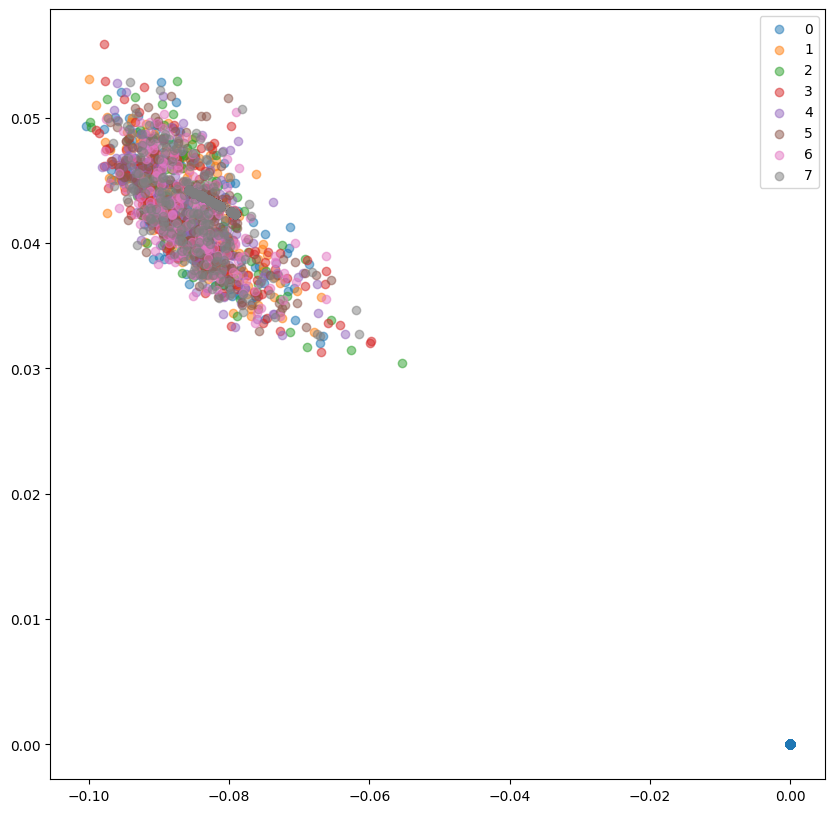

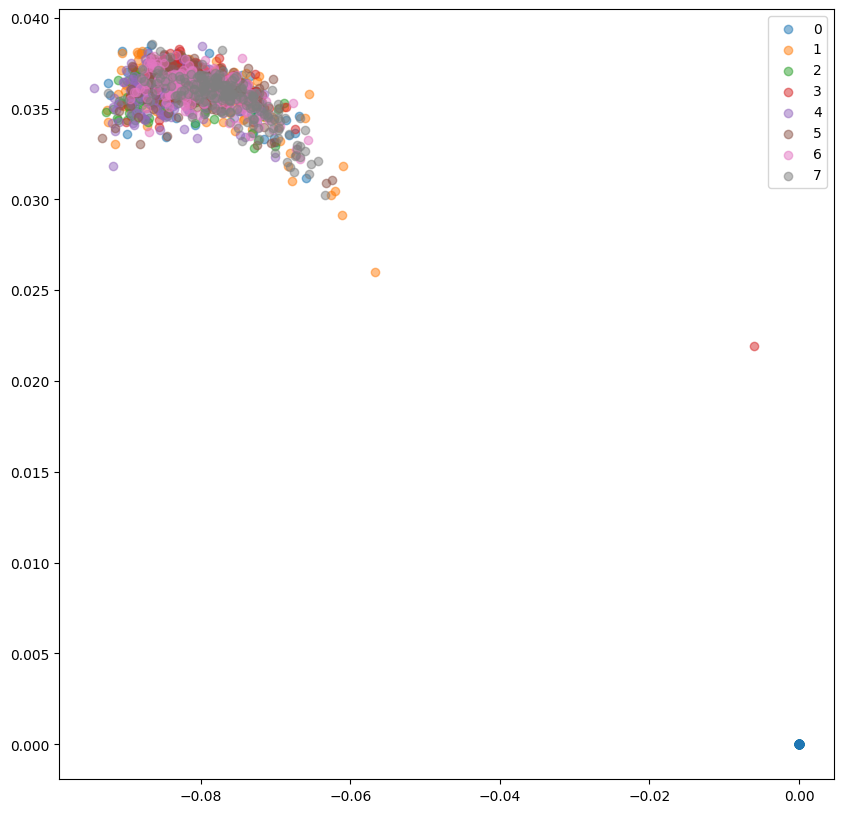

In [18]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7']
colors = [ '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(8):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for songs, genre in dataloader:
            if cuda:
                songs = songs.cuda()
            embeddings[k:k+len(songs)] = model.get_embedding(songs).data.cpu().numpy()
            labels[k:k+len(songs)] = genre.numpy()
            k += len(songs)
    return embeddings, labels

train_embeddings_ocl, train_labels_ocl = extract_embeddings(audio_train_loader, embedding_model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(audio_val_loader, embedding_model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

In [ ]:
runtime.unassign()